In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Load the training dataset
df_train = pd.read_csv("hf://datasets/christophsonntag/OLID/train.csv")

# Load the test dataset
df_test = pd.read_csv("hf://datasets/christophsonntag/OLID/test.csv")

# Extract tweets and labels from both datasets
train_tweets = np.array(df_train['tweet'].values)
train_labels = np.where(df_train['subtask_a'].values == 'OFF', 1, 0)

test_tweets = np.array(df_test['tweet'].values)
test_labels = np.where(df_test['subtask_a'].values == 'OFF', 1, 0)

print(train_tweets.shape)
print(train_labels.shape)
print(test_tweets.shape)
print(test_labels.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(13240,)
(13240,)
(860,)
(860,)


### Creating tokenizer to turn testing and training tweets into tokens for the BERT model

In [4]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize training and test tweets
train_encodings = tokenizer(list(train_tweets), padding="max_length", truncation=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(list(test_tweets), padding="max_length", truncation=True, max_length=128, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Converting the tokens and labels of training and testing into the form the BERT model is expecting (which is a Dataset class)

In [5]:
import torch
from torch.utils.data import Dataset

class OLIDDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Convert tokenized data into datasets
train_dataset = OLIDDataset(train_encodings, train_labels)
test_dataset = OLIDDataset(test_encodings, test_labels)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 13240
Test set size: 860


### Set up pre-trained BERT model and creater a trainer for it using our specific data set.

In [6]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

# Load BERT model with dropout regularization
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="best",  # Save only the best model
    load_best_model_at_end=True,  # Fix for EarlyStoppingCallback
    metric_for_best_model="eval_loss",  # Ensure best model is based on validation loss
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_dir="./logs",
    fp16=True,
    learning_rate=3e-6,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train the model

In [7]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: fakalizak (fakalizak-michigan-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.466427
2,0.584100,0.386002
3,0.463300,0.374223
4,0.440900,0.370233
5,0.428300,0.370460


TrainOutput(global_step=2070, training_loss=0.4771631369844151, metrics={'train_runtime': 197.4942, 'train_samples_per_second': 335.2, 'train_steps_per_second': 10.481, 'total_flos': 4354487966208000.0, 'train_loss': 0.4771631369844151, 'epoch': 5.0})

### Code to check which checkpoint corresponds to the best model. This the model we'll load to use.

In [8]:
import json
import os

best_checkpoint = None
best_loss = float("inf")

for checkpoint in os.listdir("./results"):
    path = f"./results/{checkpoint}/trainer_state.json"

    if os.path.exists(path):
        with open(path, "r") as f:
            data = json.load(f)
            val_loss = data["log_history"][-1].get("eval_loss", None)  # Get last validation loss

            if val_loss is not None:
                print(f"Checkpoint: {checkpoint}, Validation Loss: {val_loss}")

                # Find the checkpoint with the lowest validation loss
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_checkpoint = checkpoint

print(f"\nBest checkpoint: {best_checkpoint} with Validation Loss: {best_loss}")


Checkpoint: checkpoint-828, Validation Loss: 0.3860015273094177
Checkpoint: checkpoint-414, Validation Loss: 0.4664272665977478
Checkpoint: checkpoint-1242, Validation Loss: 0.3742227554321289
Checkpoint: checkpoint-1656, Validation Loss: 0.3702326714992523

Best checkpoint: checkpoint-1656 with Validation Loss: 0.3702326714992523


### Running model on test data to generate predictions

In [11]:
from transformers import BertForSequenceClassification

# Load the best model
best_checkpoint = "./results/checkpoint-1656"
best_model = BertForSequenceClassification.from_pretrained(best_checkpoint)

# Save the best model
best_model.save_pretrained("./final_bert_model")
tokenizer.save_pretrained("./final_bert_model")

('./final_bert_model/tokenizer_config.json',
 './final_bert_model/special_tokens_map.json',
 './final_bert_model/vocab.txt',
 './final_bert_model/added_tokens.json')

Getting predictions using the model on the testing data

In [12]:
import torch
from sklearn.metrics import classification_report

# Get predictions from BERT
preds = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(preds.predictions), axis=1)

# Print classification report
print(classification_report(test_labels, pred_labels.numpy()))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       620
           1       0.78      0.65      0.71       240

    accuracy                           0.85       860
   macro avg       0.83      0.79      0.81       860
weighted avg       0.85      0.85      0.85       860



## Using RoBERTa and DistilBERT models for prediction

In [14]:
from transformers import RobertaForSequenceClassification, DistilBertForSequenceClassification

roberta_model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    dropout=0.2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from transformers import RobertaTokenizer, DistilBertTokenizer

# Load pre-trained RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize tweets
roberta_train_encodings = roberta_tokenizer(
    list(train_tweets),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

roberta_test_encodings = roberta_tokenizer(
    list(test_tweets),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Load pre-trained DistilBERT tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize tweets
distilbert_train_encodings = distilbert_tokenizer(
    list(train_tweets),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

distilbert_test_encodings = distilbert_tokenizer(
    list(test_tweets),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

In [18]:
# Convert tokenized data into datasets
roberta_train_dataset = OLIDDataset(roberta_train_encodings, train_labels)
roberta_test_dataset = OLIDDataset(roberta_test_encodings, test_labels)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 13240
Test set size: 860


In [19]:
distilbert_train_dataset = OLIDDataset(distilbert_train_encodings, train_labels)
distilbert_test_dataset = OLIDDataset(distilbert_test_encodings, test_labels)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 13240
Test set size: 860


### RoBERTa model training and testing

In [28]:
roberta_trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=roberta_train_dataset,
    eval_dataset=roberta_test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

roberta_trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.357121
2,0.415700,0.375999


TrainOutput(global_step=828, training_loss=0.4025330658696124, metrics={'train_runtime': 49.411, 'train_samples_per_second': 1339.782, 'train_steps_per_second': 41.893, 'total_flos': 1741795186483200.0, 'train_loss': 0.4025330658696124, 'epoch': 2.0})

In [30]:
best_checkpoint = None
best_loss = float("inf")

for checkpoint in os.listdir("./results"):
    path = f"./results/{checkpoint}/trainer_state.json"

    if os.path.exists(path):
        with open(path, "r") as f:
            data = json.load(f)
            val_loss = data["log_history"][-1].get("eval_loss", None)  # Get last validation loss

            if val_loss is not None:
                print(f"Checkpoint: {checkpoint}, Validation Loss: {val_loss}")

                # Find the checkpoint with the lowest validation loss
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_checkpoint = checkpoint

print(f"\nBest checkpoint: {best_checkpoint} with Validation Loss: {best_loss}")

Checkpoint: checkpoint-828, Validation Loss: 0.3880455791950226
Checkpoint: checkpoint-414, Validation Loss: 0.3571214973926544
Checkpoint: checkpoint-1242, Validation Loss: 0.38220342993736267
Checkpoint: checkpoint-2070, Validation Loss: 0.37790271639823914
Checkpoint: checkpoint-1656, Validation Loss: 0.37880057096481323

Best checkpoint: checkpoint-414 with Validation Loss: 0.3571214973926544


In [31]:
# Load the best model
best_checkpoint = "./results/checkpoint-414"
best_model = RobertaForSequenceClassification.from_pretrained(best_checkpoint)

# Save the best model
best_model.save_pretrained("./final_roberta_model")
tokenizer.save_pretrained("./final_roberta_model")

('./final_roberta_model/tokenizer_config.json',
 './final_roberta_model/special_tokens_map.json',
 './final_roberta_model/vocab.txt',
 './final_roberta_model/added_tokens.json')

In [32]:
# Get predictions from RoBERTa
preds = roberta_trainer.predict(roberta_test_dataset)
pred_labels = torch.argmax(torch.tensor(preds.predictions), axis=1)

# Print classification report
print(classification_report(test_labels, pred_labels.numpy()))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       620
           1       0.68      0.78      0.73       240

    accuracy                           0.84       860
   macro avg       0.80      0.82      0.81       860
weighted avg       0.85      0.84      0.84       860



### DistilBERT model training and testing

In [33]:
distilbert_trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=distilbert_train_dataset,
    eval_dataset=distilbert_test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

distilbert_trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.373539
2,0.400700,0.370366
3,0.380000,0.371258


TrainOutput(global_step=1242, training_loss=0.388243166912773, metrics={'train_runtime': 40.9829, 'train_samples_per_second': 1615.307, 'train_steps_per_second': 50.509, 'total_flos': 1315401268654080.0, 'train_loss': 0.388243166912773, 'epoch': 3.0})

In [35]:
best_checkpoint = None
best_loss = float("inf")

for checkpoint in os.listdir("./results"):
    path = f"./results/{checkpoint}/trainer_state.json"

    if os.path.exists(path):
        with open(path, "r") as f:
            data = json.load(f)
            val_loss = data["log_history"][-1].get("eval_loss", None)  # Get last validation loss

            if val_loss is not None:
                print(f"Checkpoint: {checkpoint}, Validation Loss: {val_loss}")

                # Find the checkpoint with the lowest validation loss
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_checkpoint = checkpoint

print(f"\nBest checkpoint: {best_checkpoint} with Validation Loss: {best_loss}")

Checkpoint: checkpoint-828, Validation Loss: 0.37036553025245667
Checkpoint: checkpoint-414, Validation Loss: 0.37353917956352234
Checkpoint: checkpoint-1242, Validation Loss: 0.38220342993736267
Checkpoint: checkpoint-2070, Validation Loss: 0.37790271639823914
Checkpoint: checkpoint-1656, Validation Loss: 0.37880057096481323

Best checkpoint: checkpoint-828 with Validation Loss: 0.37036553025245667


In [36]:
# Load the best model
best_checkpoint = "./results/checkpoint-828"
best_model = DistilBertForSequenceClassification.from_pretrained(best_checkpoint)

# Save the best model
best_model.save_pretrained("./final_distilbert_model")
tokenizer.save_pretrained("./final_distilbert_model")

('./final_distilbert_model/tokenizer_config.json',
 './final_distilbert_model/special_tokens_map.json',
 './final_distilbert_model/vocab.txt',
 './final_distilbert_model/added_tokens.json')

In [39]:
# Get predictions from DistilBERT
preds = distilbert_trainer.predict(distilbert_test_dataset)
pred_labels = torch.argmax(torch.tensor(preds.predictions), axis=1)

# Print classification report
print(classification_report(test_labels, pred_labels.numpy()))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       620
           1       0.81      0.65      0.72       240

    accuracy                           0.86       860
   macro avg       0.84      0.80      0.81       860
weighted avg       0.86      0.86      0.85       860



### Visualization using LIME

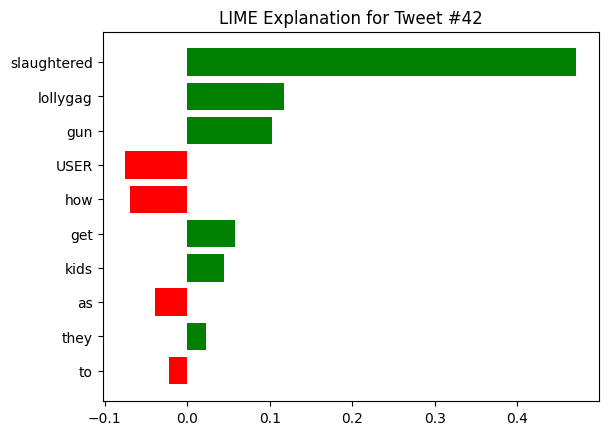

In [40]:
from lime.lime_text import LimeTextExplainer
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import matplotlib.pyplot as plt

# Load the fine-tuned model and tokenizer
model_path = "./final_bert_model"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model.eval()

# Define a prediction function for LIME
def predict_fn(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.detach().numpy()

# Pick a test tweet to explain
tweet_index = 42
tweet_text = test_tweets[tweet_index]

# Initialize LIME explainer and generate explanation
explainer = LimeTextExplainer(class_names=["Not Offensive", "Offensive"])
explanation = explainer.explain_instance(tweet_text, predict_fn, num_features=10)

# Show and save the explanation figure
fig = explanation.as_pyplot_figure()
plt.title(f"LIME Explanation for Tweet #{tweet_index}")
fig.savefig(f"lime_explanation_tweet_{tweet_index}.png", dpi=300)
plt.show()